In [ ]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from scipy.stats import skewnorm

from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

# Context
The data we will be using through the pratical classes comes from a small relational database whose schema can be seen below:
![alt text](../figures/schema.png "Relation database schema")

# Reading the Data

In [ ]:
# path to database
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select
    age, 
    income, 
    frq, 
    rcn, 
    mnt, 
    clothes, 
    kitchen, 
    small_appliances, 
    toys, 
    house_keeping,
    dependents, 
    per_net_purchase,
    g.gender, 
    e.education, 
    m.status, 
    r.description
from customers as c
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df = pd.read_sql_query(query, conn)

## Make a copy of your original dataset

why?

In [ ]:
df_original = df.copy()

In [ ]:
# CODE HERE

# Metadata
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

# Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### Take a closer look and point out possible problems:

(hint: a missing values in pandas is represented with a NaN value)

### Replicating modifications from previous notebook

In [ ]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

# count of missing values
df.isna().sum()

In [ ]:
# fix wrong dtypes
df.dependents = df.dependents.astype("boolean")  # converting to "boolean" over "bool" allows preservation of NaNs

In [ ]:
# check dataset data types again
df.dtypes

In [ ]:
# check descriptive statistics again
df.describe(include="all").T

In [ ]:
#Define metric and non-metric features. Why?
non_metric_features = ["education", "status", "gender", "dependents", "description"]
metric_features = df.columns.drop(non_metric_features).to_list()

# Data Preprocessing

## Fill missing values

https://statisticsbyjim.com/basics/missing-data/

---
<br>

Read: Section 2.4.2 

Han, J., Pei, J., & Tong, H. (2022). *Data mining: Concepts and Techniques* (4th ed.). Morgan Kaufmann.

<br>

Read: Chapter 4

García, S., Luengo, J., & Herrera, F. (2014). *Data preprocessing in data mining*. Springer.

### How can we fill missing values?

### Measures of central tendency

In [ ]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [ ]:
# count of missing values
df_central.isna().sum()

In [ ]:
means = df_central[metric_features].mean()
means

In [ ]:
medians = df_central[metric_features].median()
medians

#### Mean or Median?

In [ ]:
#####################
## You don't need to understand this code
#####################


skew_demo = np.round(skewnorm.rvs(180, size=1500, random_state=68410237)*100, 0).astype(int)

skew_md = np.median(skew_demo)
skew_mn = np.mean(skew_demo)

sns.set_theme(style="white", palette=None)

fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(skew_demo, bins=20,
             ax=ax, color='tab:orange')

ax.axvline(skew_md, color='black', linewidth=4,
           label='Median: {}'.format(int(skew_md)))
ax.axvline(skew_mn, color='blue', linestyle='dashed', linewidth=4,
           label='Mean: {}'.format(int(skew_mn)))

ax.legend(handlelength=5)

ax.set_title("Histogram")
plt.show()

sns.set()

#### What about non-numeric features?

In [ ]:
# Check each step of these commands
modes = df_central[non_metric_features].mode().loc[0]
modes

In [ ]:
# Fill NaNs on df_central
# CODE HERE

df_central[metric_features] = df_central[metric_features].fillna(medians)
df_central[non_metric_features] = df_central[non_metric_features].fillna(modes)

df_central.isna().sum()  # checking how many NaNs we still have

### KNN

In [ ]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [ ]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

In [ ]:
# KNNImputer - only works for numerical variables. Fill NaNs on df_neighbors
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])


In [ ]:
# See rows with NaNs imputed
# CODE HERE
df_neighbors[nans_index]


In [ ]:
# let's keep the central imputation
df = df_central.copy()

## An overview of our previous data exploration

You can also explore this dataset using the exported `pandas-profiling` report.




![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/categorical_variables_counts.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_histograms.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_boxplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/pairwise_numeric_scatterplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/correlation_matrix.png)

## Outlier removal

Why do we need to remove outliers? Which methods can we use?




### Outlier removal using only the IQR method

Why should you use/not use this method?

Inter-Quartile Range formula:

<br>

$IQR = Q_3 – Q_1$

<br>

---

<br>

**Outliers** are the observations that fall
- below $Q_1 − 1.5 \times IQR$

or

- above $Q_3 + 1.5 \times IQR$

<br>
<br>

https://online.stat.psu.edu/stat200/lesson/3/3.2

In [ ]:
# Compute the IQR
# HINT: Use .quantile()

# Calculate Q1, Q3, IQR

q1 = df[metric_features].quantile(.25)


In [ ]:
# Calculate Q1, Q3, IQR

q3 = df[metric_features].quantile(.75)


In [ ]:
# Calculate Q1, Q3, IQR

iqr = (q3 - q1)


In [ ]:
# Compute upper and lower limit 

# lower_limit = Q1 -1.5*IQR
lower_lim = q1 - (1.5 * iqr)

# upper_limit = Q3 + 1.5*IQR
upper_lim = q3 + (1.5 * iqr)




In [ ]:
filters_iqr = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_iqr.append(df[metric].between(llim, ulim, inclusive='neither'))

filters_iqr_all = pd.Series(np.all(filters_iqr, 0))


In [ ]:
# filters_iqr

In [ ]:
filters_iqr_all.sum()

In [ ]:
df_iqr = df[filters_iqr_all]
print('Percentage of data kept after removing outliers:', 100*(np.round(df_iqr.shape[0] / df_original.shape[0], 4)))


What do you think of this number?

In general we want to keep as much of our data as possible.

As a rule of thumb, try not to remove more than 5% of your rows. 

***This is only a rule of thumb!*** 

In some cases it really is necessary to remove more.


### Manual outlier removal

Now let's try "manually" filtering the dataset's outliers

---


Let's look at the boxplots again:

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_boxplots.png)

In [ ]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

# ( df['feature1']<= limit1 ) & ( df['feature2']<= limit2 ) ...


filters_man = (
    (df['house_keeping']<=50)
    &
    (df['kitchen']<=40)
    &
    (df['toys']<=35)
    &
    (df['education']!='OldSchool')
)

df_man = df[filters_man]

In [ ]:
print('Percentage of data kept after removing outliers:', 100*np.round(df_man.shape[0] / df_original.shape[0], 4))

## Combining different outlier methods

More robust/ consistent outlier detection method:

In [ ]:
## What is this doing?
df_out = df[(filters_iqr_all | filters_man)] 


print('Percentage of data kept after removing outliers:', np.round(df_out.shape[0] / df_original.shape[0], 4))

In [ ]:
# Get the manual filtering version

df = df_man.copy()



## Outlier threshold value

You may change the values of observations for a given variable:


In [ ]:
# Remember the 'rcn' variable had an odd behavior? 
# This is the time to fix that

# CODE HERE

In [ ]:
print((df['rcn']>100).value_counts())

rcn_t = df['rcn'].copy()
rcn_t.loc[rcn_t>100] = 100

df['rcn'] = rcn_t

### Exercise

Visualize your boxplots and histograms before and after outlier removal.


![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/boxplots_before_after_outliers.png)

## Feature Engineering

A reminder of our metadata:
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

In [ ]:
# Try to pull as many features as you can; You can always drop them later on
# You can start by converting the 'age' variable to the actual age
# You can also store the birth year in another feature

# CODE HERE

In [ ]:
new_features = []

In [ ]:
df['birth_year'] = df['age']
df['age'] = 2024 - df['birth_year']
new_features.append('birth_year')

new_features

In [ ]:
df['spent_online'] = df['per_net_purchase']*df['mnt']/100

new_features.append('spent_online')

new_features

In [ ]:
df.describe()

## Variable selection: Redundancy VS Relevancy

### Redundancy: Handling highly correlated variables

We already saw our original correlation matrix:

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/correlation_matrix.png)


In [ ]:
# Select variables according to their correlations
# Updating metric_features

## RUN THIS CELL ONLY ONCE!!!!

# CODE HERE
metric_features.append("spent_online")
metric_features.remove("mnt")
metric_features.remove("age")

metric_features


In [ ]:
# You can also drop the features from the df
# But sometimes they may be useful for cluster profiling later

# df.drop(..., inplace=True)


### Relevancy
Selecting variables based on the relevancy of each one to the task. 

Example: 
- remove uncorrelated variables with the target,
- stepwise regression,
- use variables for product clustering,
- use variables for socio-demographic clustering,
- ...

Variables that aren't correlated with any other variable are often also not relevant. In this case we will not focus on this a lot since we don't have a defined task yet.

## Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

## Data Normalization

In [ ]:
# Remember our original data

df.describe().round(2)

### MinMax Scaling

Transforms values to be between [0,1]

$
x' = \frac{x - min(X)}{max(X) - min(X)}
$

<br>
<br>

where:

$x$ is an original value

$x'$ is the normalized value

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [ ]:
## Let's look at an example:

demo_ages = pd.DataFrame({"Age": [14, 24, 22, 18, 18, 26, 11, 23, 13, 12]})
demo_ages

In [ ]:

# How to do this with Python/Pandas?
#  ( demo_ages - min(demo_ages) ) 
# --------------------------------- 
#  max(demo_ages) - min(demo_ages)

demo_ages


In [ ]:
min_age = demo_ages["Age"].min() # finish this line
max_age = demo_ages["Age"].max() # finish this line

mm_age = (demo_ages['Age'] - min_age)/(max_age-min_age) # finish this line


Remember the formula:

$
x' = \frac{x - min(X)}{max(X) - min(X)}
$

<br>
<br>

where:

$x$ is an original value

$x'$ is the normalized value


(This is not showing all rows)


Age (Orig) | Formula        | Result
-----------|----------------|-------
14         | (14 - 11) / 15 | 0.2
24         | (24 - 11) / 15 | 0.86666667
26         | (26 - 11) / 15 | 1
11         | (11 - 11) / 15 | 0






In [ ]:
demo_ages['Age']

In [ ]:
# sklearn makes it even easier:

demo_ages["Age_minmax"] = MinMaxScaler().fit_transform(demo_ages[['Age']])

demo_ages

#### Now do it for our dataset

In [ ]:
df_minmax = df.copy()

In [ ]:
# Use MinMaxScaler to scale the data
mm_scaler = MinMaxScaler()
mm_scaled_feat = mm_scaler.fit_transform(df_minmax[metric_features])
mm_scaled_feat

In [ ]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n")
pd.DataFrame([mm_scaler.data_min_, mm_scaler.data_max_], columns=metric_features, index=['min','max'])

In [ ]:
## Replace original metric_features values with mm_scaled_feat values
df_minmax[metric_features] = mm_scaled_feat

In [ ]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().round(2)

In [ ]:
df_minmax[metric_features].head()

In [ ]:
df[metric_features].head()

### Standard Scaling

AKA Z-Score Scaling

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

$z = (x - u) / s$

where:

$u$ is the mean of the training samples,

$s$ is the standard deviation of the training samples

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [ ]:
## Let's see the age demo again

demo_ages


$z = (x - u) / s$

where:

$u$ is the mean of the training samples,

$s$ is the standard deviation of the training samples


In [ ]:
## u = mean of age
## s = std of age

# How to do this in Python/Pandas?
# ( demo_ages - mean(demo_ages) )
# -------------------------------
#        std(demo_ages)

In [ ]:
## u = mean of age
## s = std of age

mean_age = demo_ages["Age"].mean()
std_age  = demo_ages["Age"].std(ddof = 0) # to match sklearn implementation of std


In [ ]:
(demo_ages["Age"] - mean_age) / std_age

In [ ]:
# Or use sklearn:

demo_ages["Age_standard"] = StandardScaler().fit_transform(demo_ages[["Age"]])

demo_ages

In [ ]:
demo_ages.describe().round(2)

#### Now do it for our dataset

In [ ]:
df_standard = df.copy()

In [ ]:
ss_scaler = StandardScaler()
ss_scaled_feat = ss_scaler.fit_transform(df_standard[metric_features])
ss_scaled_feat

In [ ]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n")
pd.DataFrame([ss_scaler.mean_, np.sqrt(ss_scaler.var_)], columns=metric_features, index=['mean','std'])

In [ ]:
df_standard[metric_features] = ss_scaled_feat
df_standard.head()

In [ ]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

**Important**: What if we had a training and test set? Should we fit a Scaler in both? What about other Sklearn objects?

## Compare MinMaxScaler vs StandardScaler vs Original data

### Boxplots

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2,3, figsize=(8,5), tight_layout=True, sharex='col', sharey='row')

bp_feat_l = 'house_keeping'

sns.boxplot(df_original, x=bp_feat_l, ax=axes[0][0], width=.4)
axes[0][0].set_title('Original')
axes[0][0].set_ylabel(bp_feat_l)

sns.boxplot(df_minmax, x=bp_feat_l, ax=axes[0][1], width=.4)
axes[0][1].set_title('MinMaxScaler()')

sns.boxplot(df_standard, x=bp_feat_l, ax=axes[0][2], width=.4)
axes[0][2].set_title('StandardScaler()')



bp_feat_r = 'income'

sns.boxplot(df_original, x=bp_feat_r, ax=axes[1][0], width=.4)
axes[1][0].set_ylabel(bp_feat_r)

sns.boxplot(df_minmax, x=bp_feat_r, ax=axes[1][1], width=.4)

sns.boxplot(df_standard, x=bp_feat_r, ax=axes[1][2], width=.4)


axes[1][0].set_xlabel(None)
axes[1][1].set_xlabel(None)
axes[1][2].set_xlabel(None)

fig.suptitle('Boxplots: "{}" and "{}"'.format(bp_feat_l, bp_feat_r))
plt.show()

### Histograms

What about histograms?

**Exercise**: Visualize histograms here, compare the shapes of the original distribution with the MinMaxScaler and StandardScaler results.

In [ ]:
sns.set_style('whitegrid')

# Create subplots with 3 rows, 1 column:
fig, axes = plt.subplots(3,1, 
                         figsize=(5,5), tight_layout=True)

# Which feature do you want to visualize?
hp_feat = 'house_keeping'

# common function args for histplot
hp_args = dict(x=hp_feat, bins=15)


sns.histplot(df_original, ax=axes[0], **hp_args)
axes[0].set_title('{}: Original'.format(hp_feat))
axes[0].set_xlabel(None)

sns.histplot(df_minmax, ax=axes[1], **hp_args)
axes[1].set_title('{}: MinMaxScaler()'.format(hp_feat))
axes[1].set_xlabel(None)

sns.histplot(df_standard, ax=axes[2], **hp_args)
axes[2].set_title('{}: StandardScaler()'.format(hp_feat))
axes[2].set_xlabel(None)


plt.show()

sns.set()

In [ ]:
sns.set()

#### Keep StandardScaler

In [ ]:
df = df_standard.copy()

## One-hot encoding

In [ ]:
df_ohc = df.copy()

In [ ]:
# First let's remove status=Whatever
df_ohc.loc[df_ohc['status'] == 'Whatever', 'status'] = df['status'].mode()[0]

In [ ]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse_output=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()


In [ ]:
# Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()


In [ ]:
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df

In [ ]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc, ohc_df], axis=1)
df_ohc.head()

In [ ]:
df = df_ohc.copy()

In [ ]:
list(df.columns)

In [ ]:
# You can also choose to drop the original non_metric_features from your df
# df.drop(columns=non_metric_features)

### Rename OHE columns

In [ ]:
## Rename OHE columns from "feature_val_a" to "oh_feature_val_a"
## e.g. status_Widow to oh_status_Widow
## We do this to be able to distinguish the OHE columns more easily later

## Assemble OHE columns and their new column names
rename_ohe_cols = {}

for i in non_metric_features:
    for j in df.columns[df.columns.str.startswith(i)].to_list() :
        if j not in non_metric_features:
            rename_ohe_cols[j] = 'oh_' + j

df.rename(columns=rename_ohe_cols, inplace=True)


In [ ]:
df

In [ ]:
list(df.columns)

## Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

#### A tool to assist you through your exploratory data analysis

Optionally, you may use `pandas-profiling` in your data analysis. 

Remember, although this tool provides excelent insights about the data you're working with, it is not enough to perform a proper analysis.

In [ ]:

# ProfileReport(
#     df,
#     title='Tugas Customer Data Preprocessed',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

## Dimensionality Reduction

In [ ]:
df

In [ ]:
df_pca = df.copy()


### [A more specific explanation of PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

![](https://builtin.com/sites/www.builtin.com/files/inline-images/national/Principal%2520Component%2520Analysis%2520second%2520principal.gif)


> (Han, 2023)
> Data Mining concepts and techniques (4th ed.)
> 
> 
> The basic procedure is as follows:
> 
> 1. The input data are normalized, so that each attribute falls within the same range. This step helps ensure that attributes with large domains will not dominate attributes with smaller domains.
> 2. PCA computes k orthonormal vectors that provide a basis for the normalized input data. These are unit vectors that are perpendicular with each other. These vectors are referred to as the principal components. The input data are a linear combination of the principal components.
> 3. The principal components are sorted in order of decreasing “significance” or strength. The principal components essentially serve as a new set of axes for the data, providing important information about variance. That is, the sorted axes are such that the first axis shows the most variance among the data, the second axis shows the next highest variance, and so on. For example, Fig. 2.17 shows the first two principal components, $Y_1$ and $Y_2$, for the given set of data originally mapped to the axes $X_1$ and $X_2$. This information helps identify groups or patterns within the data.
> 4. Because the components are sorted in descending order of “significance,” the data size can be reduced by eliminating the weaker components, that is, those with low variance. Using the strongest principal components, it should be possible to reconstruct a good approximation of the original data.
>
>
> 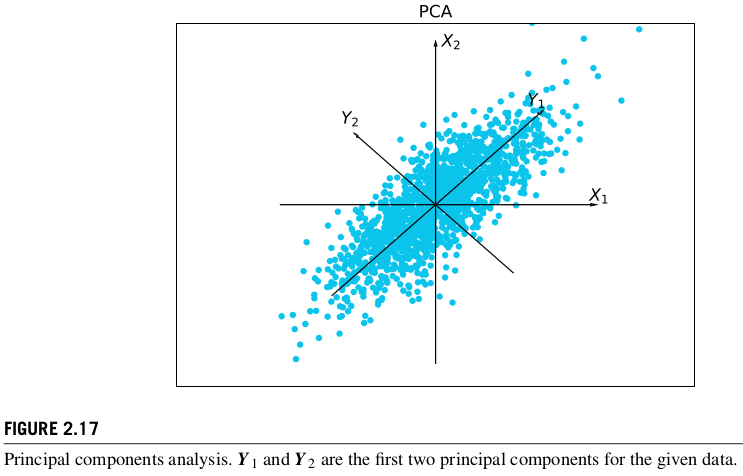
>
>  
> Han, J., Pei, J., & Tong, H. (2023). Data, measurements, and data preprocessing. In Elsevier eBooks (pp. 23–84). https://doi.org/10.1016/b978-0-12-811760-6.00012-6
> 

---



A more detailed explanation of PCA: (500 pages book)

Jolliffe, I. T. (2002). Principal component analysis. Springer New York.
 [[link]](http://cda.psych.uiuc.edu/statistical_learning_course/Jolliffe%20I.%20Principal%20Component%20Analysis%20(2ed.,%20Springer,%202002)(518s)_MVsa_.pdf)

In [ ]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = None # CODE HERE
pca_feat  # What is this output?

### How many Principal Components to retain?



Some heuristics (rules of thumb):

Reference: **Jolliffe, I. T. (2002). Principal component analysis.**

Section 6.1: *How Many Principal Components?*

- 6.1.1. Cumulative percentage of total variance
- 6.1.2. Kaiser's rule
- 6.1.3. Scree plot


**Exercise:**



[Read the scikit-learn documentation about PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

Fill the correct values in the next cell:

In [ ]:
# Get PCA output as table

# Get the eigenvalues (explained variance)
explained_variance = None 

# Get the explained variance ratio
explained_variance_ratio = None 

# get the cumulative explained variance ratio 
# Hint: use np.cumsum()
cumulative_explained_variance_ratio = None 

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

**Now let's plot the results**

*[What's a "scree"?](https://en.wikipedia.org/wiki/Scree)*

In [ ]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio, # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio, # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [ ]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  
pca_df

In [ ]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

### How do we interpret each Principal Component (with style)?

In [ ]:
# CODE HERE: Get the loadings
# (i.e. the correlations between Principal Components and the original features)
# Hint: Use df.corr()
# Hint: Filter the correlation matrix to show the PC as columns, and original features as rows

loadings = None 


In [ ]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings.style.map(_color_red_or_green)

In [ ]:
df = df_pca.copy()

**Some final data preprocessing**

In [ ]:
# Do this after checking the new pandas profiling report
# DROP PC3. 
# Why?



In [ ]:
df

## Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

In [ ]:

# ProfileReport(
#     df,
#     title='Tugas Customer Data Preprocessed',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

**Is everything as you expect it to be? Save the data for later use.**

In [ ]:
# df.to_csv(os.path.join("..", "data", "data_preprocessed.csv"), index=False)

#### Some references 

##### Data Preprocessing

**Data Mining Concepts and Techniques 4th ed.**

Sections:
- 2.4: Data quality, data cleaning, and data integration
- 2.5: Data transformation
- 2.6: Dimensionality reduction

Han, J., Pei, J., & Tong, H. (2022). *Data mining: Concepts and Techniques*. Morgan Kaufmann.

**Data Mining Concepts and Techniques 3rd ed.**

Chapter 3: Data Preprocessing

Han, J., Kamber, M. & Pei, J. (2012). *Data mining concepts and techniques*, third edition Morgan Kaufmann Publishers


##### Principal Components Analysis

Book:

**Principal component analysis**

Jolliffe, I. T. (2002). Principal component analysis. Springer New York.

Websites:

https://builtin.com/data-science/step-step-explanation-principal-component-analysis